In [1]:
import openpyxl
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import statsmodels.api as sm

import itertools
import optuna

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [18]:
sm.tools.print_version.show_versions(show_dirs=True)
rcParams['figure.figsize'] = 12, 10


INSTALLED VERSIONS
------------------
Python: 3.7.2.final.0

statsmodels

Installed: 0.13.5 (C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels)

Required Dependencies

cython: 0.29.6 (C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\Cython)
numpy: 1.21.6 (C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\numpy)
scipy: 1.7.3 (C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\scipy)
pandas: 1.3.5 (C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\pandas)
    dateutil: 2.8.0 (C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\dateutil)
patsy: 0.5.6 (C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\patsy)

Optional Dependencies

matplotlib: 3.0.3 (C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\matplotlib)
    backend: module://ipykernel.pylab.backend_inline 
cvxopt: Not installed
joblib: 0.13.2 (C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\joblib)

Developer Tools

IPython: 7.3.0 (C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\IPython)
    jinja2: 2.10 (C

In [19]:
wb1 = openpyxl.load_workbook(r"data_sheets\Книга1.xlsx")
sheet = wb1['Лист4']

In [20]:
def df_test(frame_col):
    print('Результат теста:')
    df_result = adfuller(frame_col)
    df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for result_value, label in zip(df_result, df_labels):
        print(label + ' : ' + str(result_value))

    if df_result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
        return True
    else:
        print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")
        return False

300 300


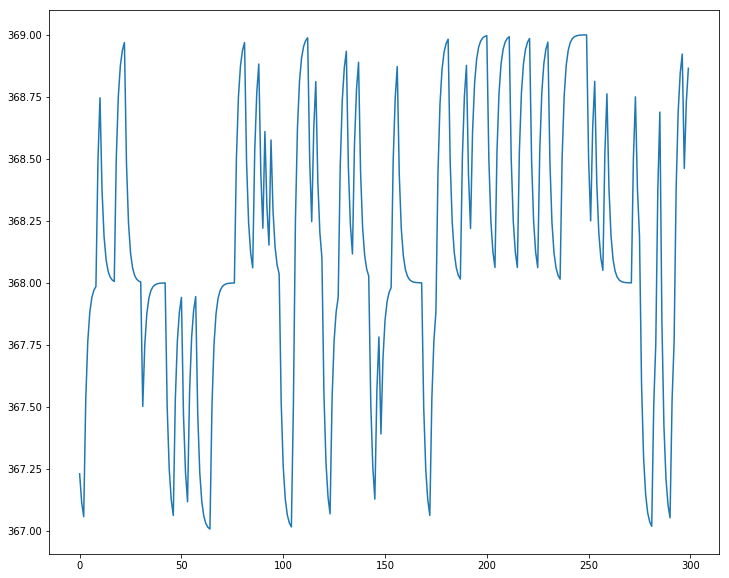

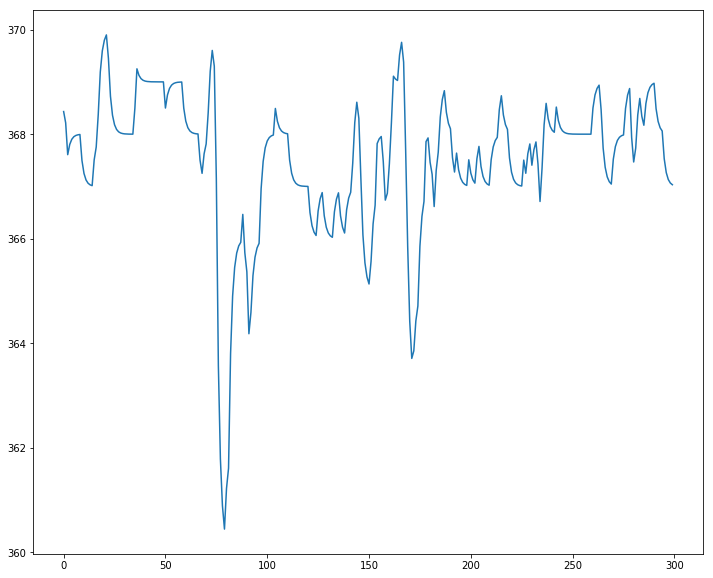

In [118]:
start = datetime.datetime.now()
timer_train = []
timer_test = []
batch_train = []
batch_test = []
n = 4000
border = 4300
num = 4600
for i in range (0, border-n):
    timer_train.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_train.append(float(sheet.cell(row = i+n, column = 2).value))
for j in range (border-n, num-n):
    timer_test.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_test.append(float(sheet.cell(row = j+n, column = 2).value))
print(len(batch_train), len(batch_test))
plt.plot(batch_train)
plt.show()
plt.plot(batch_test)
plt.show()

Результат теста:
ADF Test Statistic : -7.404216687979
p-value : 7.41773346436768e-11
#Lags Used : 8
Number of Observations Used : 290
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


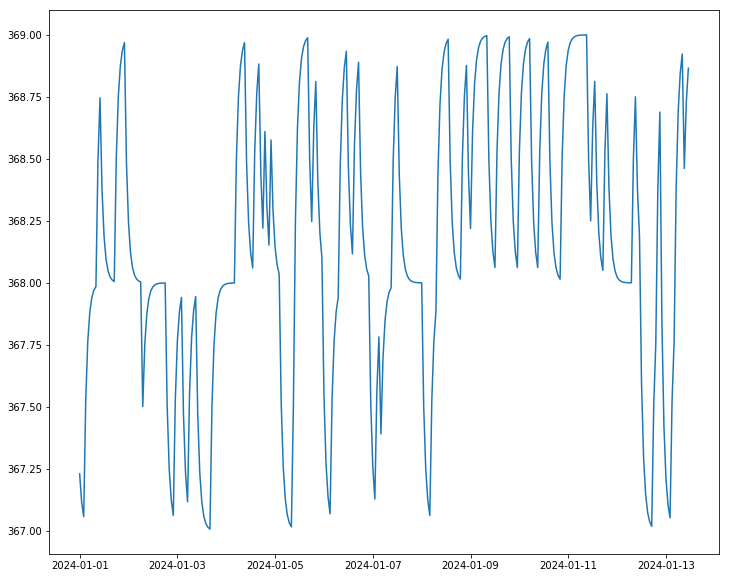

In [159]:
df1 =  pd.DataFrame(columns = ["flow1", "time"])
df1.time = timer_train
df1.flow1 = batch_train
df1_diff = df1.diff().dropna()
while(df_test(df1_diff['flow1']) != True):
    df1_diff = df1_diff.diff().dropna()
df1.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df1['flow1']), freq='h')
df1_diff.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df1_diff['flow1']), freq='h')
plt.plot(df1['flow1'])

Результат теста:
ADF Test Statistic : -3.2791549969330784
p-value : 0.01583635058577201
#Lags Used : 7
Number of Observations Used : 292
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


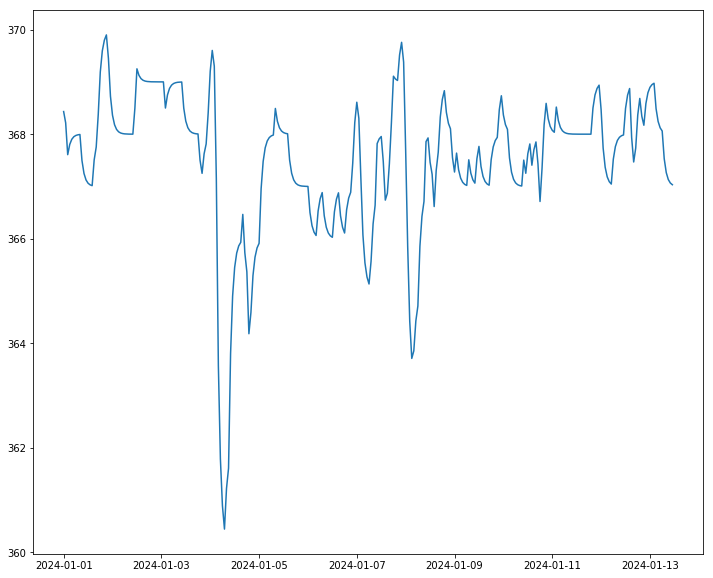

In [160]:
df2 =  pd.DataFrame(columns = ["flow1", "time"])
df2.time = timer_test
df2.flow1 = batch_test
df2_diff = df2.diff().dropna()
while((df_test(df2['flow1']) != True) and (i in range (1, 10))):
    df2_diff = df2_diff.diff().dropna()
df2.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df2['flow1']), freq='h')
df2_diff.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df2_diff['flow1']), freq='h')
plt.plot(df2['flow1'])

In [285]:
period = 48
fit1 = ExponentialSmoothing(
    df2['flow1'],
    use_boxcox=True,
    initialization_method="heuristic",
    seasonal_periods = period,
    trend="add",
    seasonal="add",
).fit()
fit2 = ExponentialSmoothing(
    df2['flow1'],
    use_boxcox=True,
    damped_trend=True,
    initialization_method="estimated",
    seasonal_periods = period,
    trend="add",
    seasonal="add",
).fit()
fit3 = ExponentialSmoothing(
    df2['flow1'],
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
    seasonal_periods = period,
    trend="add",
    seasonal="add",
).fit()
fit4 = ExponentialSmoothing(
    df2['flow1'],
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
    seasonal_periods = period,
    trend="add",
    seasonal="add",
).fit()

In [286]:
forecast1 = fit1.forecast(len(df1['flow1']))
forecast2 = fit2.forecast(len(df1['flow1']))
forecast3 = fit3.forecast(len(df1['flow1']))
forecast4 = fit4.forecast(len(df1['flow1']))

In [287]:
predictions1 = pd.Series(forecast1.values, index=df2["flow1"].index)
predictions2 = pd.Series(forecast2.values, index=df2["flow1"].index)
predictions3 = pd.Series(forecast3.values, index=df2["flow1"].index)
predictions4 = pd.Series(forecast4.values, index=df2["flow1"].index)

In [288]:
difference = np.mean(predictions4 - df2['flow1'])
forecast_mse1 = np.sqrt(((predictions4 - df2['flow1']) ** 2).mean())
print(forecast_mse1, difference)
predictions_final = (predictions1 + predictions2+predictions3+predictions4)/4
print(predictions4)

7.793191934969816 -6.558371042510256
2024-01-01 00:00:00    366.986671
2024-01-01 01:00:00    366.666588
2024-01-01 02:00:00    366.348801
2024-01-01 03:00:00    366.151370
2024-01-01 04:00:00    366.179378
                          ...    
2024-01-13 07:00:00    360.382636
2024-01-13 08:00:00    360.262027
2024-01-13 09:00:00    361.071286
2024-01-13 10:00:00    361.832032
2024-01-13 11:00:00    362.122036
Freq: H, Length: 300, dtype: float64


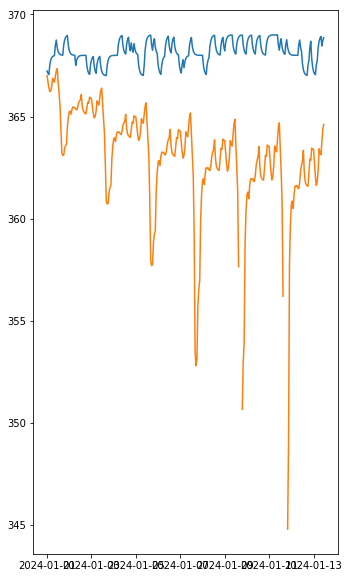

In [289]:
  
figure = pylab.subplot(1,2,2)
figure1 = pylab.plot(df1['flow1'], label = "истинные значения")
figure2 = pylab.plot(predictions_final, label = "прогноз 1")